## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [38]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.lines import Line2D  # For custom legend

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


### 1.1 View Data

In [39]:
local_results_folder = Path("./Memento_V01")
file_patterns = {
    #"perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "nginx": "*nginx*.csv",
}

#### Example of each data file

In [40]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_1replicas_scenario12_100rps.csv ===


,System - Date,System - Time,System - IPC,System - L3MISS,System - L2MISS,System - READ,System - WRITE,System - PhysIPC,System - PhysIPC%,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,System Pack C-States - C0res%,System Pack C-States - C6res%
0,2025-07-01,03:17:37.190,1.32,0.07,0.45,1.25,0.16,2.64,52.74,0.68,75.08,0.0,97.85,0.07
1,2025-07-01,03:17:42.191,1.31,0.06,0.45,1.06,0.13,2.62,52.41,0.69,77.08,0.0,99.04,0.02
2,2025-07-01,03:17:47.191,1.32,0.07,0.47,1.10,0.14,2.65,52.95,0.71,76.12,0.0,98.92,0.01
3,2025-07-01,03:17:52.192,1.35,0.05,0.43,0.99,0.12,2.69,53.83,0.70,76.70,0.0,99.23,0.02
4,2025-07-01,03:17:57.192,1.30,0.08,0.50,1.13,0.14,2.60,52.03,0.71,76.55,0.0,98.74,0.03




=== Category: pcm_cores - File: pcm_core_1replicas_scenario31_3000rps.csv ===


,System - Date,System - Time,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,SKT0 Core C-State - C0res%,SKT0 Core C-State - C1res%,SKT0 Core C-State - C6res%,Core0 (Socket 0) - IPC,Core0 (Socket 0) - L3MISS,...,Core6 (Socket 0) - PhysIPC,Core6 (Socket 0) - PhysIPC%,Core7 (Socket 0) - IPC,Core7 (Socket 0) - L3MISS,Core7 (Socket 0) - L2MISS,Core7 (Socket 0) - C0res%,Core7 (Socket 0) - C1res%,Core7 (Socket 0) - C6res%,Core7 (Socket 0) - PhysIPC,Core7 (Socket 0) - PhysIPC%
0,2025-07-01,09:47:02.180,1.13,91.81,0.0,1.13,91.81,0.0,0.76,0.02,...,2.07,41.37,0.72,0.01,0.55,1.54,88.40,0.0,1.44,28.72
1,2025-07-01,09:47:07.181,1.31,98.69,0.0,1.31,98.69,0.0,0.75,0.01,...,2.10,42.07,0.72,0.01,0.64,1.80,98.20,0.0,1.43,28.67
2,2025-07-01,09:47:12.181,1.18,98.82,0.0,1.18,98.82,0.0,0.71,0.02,...,2.09,41.77,0.73,0.02,0.66,1.89,98.11,0.0,1.45,29.06
3,2025-07-01,09:47:17.181,1.33,98.67,0.0,1.33,98.67,0.0,0.85,0.02,...,2.07,41.43,0.73,0.02,0.66,1.91,98.09,0.0,1.47,29.38
4,2025-07-01,09:47:22.181,1.30,98.70,0.0,1.30,98.70,0.0,0.62,0.01,...,2.13,42.56,0.72,0.02,0.70,1.81,98.19,0.0,1.44,28.73




=== Category: nginx - File: nginx_metrics.csv ===


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0
1,1replicas_scenario1_100rps,1,Baseline1,1,100,100.005295,0.307,0.317,0.0,0.493,0.548,0.598,1.136,0
2,1replicas_scenario2_100rps,1,Baseline2,2,100,100.005002,0.305,0.314,0.0,0.489,0.546,0.600,3.619,0
3,1replicas_scenario11_100rps,1,1_iBench_CPU_pod,11,100,100.005151,0.337,0.314,0.0,0.501,0.562,1.756,3.351,0
4,1replicas_scenario12_100rps,1,2_iBench_CPU_pods,12,100,100.005424,0.331,0.307,0.0,0.476,0.548,1.443,6.777,0


#### Columns in each data file

In [41]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_1replicas_scenario12_100rps.csv ===
['System - Date', 'System - Time', 'System - IPC', 'System - L3MISS', 'System - L2MISS', 'System - READ', 'System - WRITE', 'System - PhysIPC', 'System - PhysIPC%', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'System Pack C-States - C0res%', 'System Pack C-States - C6res%']


=== Category: pcm_cores - File: pcm_core_1replicas_scenario31_3000rps.csv ===
['System - Date', 'System - Time', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'SKT0 Core C-State - C0res%', 'SKT0 Core C-State - C1res%', 'SKT0 Core C-State - C6res%', 'Core0 (Socket 0) - IPC', 'Core0 (Socket 0) - L3MISS', 'Core0 (Socket 0) - L2MISS', 'Core0 (Socket 0) - C0res%', 'Core0 (Socket 0) - C1res%', 'Core0 (Socket 0) - C6res%', 'Core0 (Socket 0) - PhysIPC', 'Core0 (Socket 0) - PhysIPC%', 'Core1 (Socket 0) - IPC', 'Core1 (Socket 0) - L3MISS',

In [42]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

In [43]:
Data_Dir = 'The_Substance_V01'
Perfomance_File = os.path.join(Data_Dir, 'nginx_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)
    print("Loaded performance metrics:")
    display(df_perf)
    print(df_perf.shape)
else:
    print(f"Performance file not found at {Perfomance_File}. Please verify path.")
    df_perf = pd.DataFrame()

Loaded performance metrics:


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,balanced_1replicas_scenario0_1500rps,balanced_1,Baseline0,0,1500,1500.005476,0.092,0.090,0.0,0.110,0.119,0.149,3.392,0
1,balanced_1replicas_scenario1_1500rps,balanced_1,Baseline1,1,1500,1500.004384,0.092,0.089,0.0,0.110,0.118,0.149,4.452,0
2,balanced_1replicas_scenario2_1500rps,balanced_1,Baseline2,2,1500,1500.005273,0.092,0.090,0.0,0.111,0.119,0.150,3.436,0
3,balanced_1replicas_scenario11_1500rps,balanced_1,1_iBench_CPU_pod,11,1500,1500.005986,0.098,0.090,0.0,0.114,0.131,0.221,5.923,0
4,balanced_1replicas_scenario12_1500rps,balanced_1,2_iBench_CPU_pods,12,1500,1500.007422,0.110,0.091,0.0,0.117,0.142,0.347,4.845,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,weighted_3_2replicas_scenario24_1500rps,weighted_3_2,4_stress-ng_l3_pods,24,1500,1500.004579,0.478,0.432,0.0,0.806,1.020,1.918,6.715,0
131,weighted_3_2replicas_scenario31_1500rps,weighted_3_2,1_iBench_memBW_pod,31,1500,1500.003899,0.098,0.094,0.0,0.121,0.132,0.172,3.737,0
132,weighted_3_2replicas_scenario32_1500rps,weighted_3_2,2_iBench_memBW_pods,32,1500,1500.002396,0.112,0.098,0.0,0.162,0.190,0.260,5.721,0
133,weighted_3_2replicas_scenario33_1500rps,weighted_3_2,3_iBench_memBW_pods,33,1500,1500.005578,0.113,0.103,0.0,0.153,0.179,0.247,3.938,0


(135, 14)


### 1.3 Combine Data from Different Tests

In [ ]:
import os
import pandas as pd

# Folders that I will use for the analysis
folders = ["Memento_V01", "Memento_V02", "Memento_V03", "Memento_V04","Memento_V02_3_MixedScenarios", "Memento_V01_mix_scenarios"]

def load_and_average_perf_data(folders, filename="nginx_metrics.csv"):
    all_data = []

    for folder in folders:
        filepath = os.path.join(folder, filename)
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            df["FolderID"] = folder
            df["UniqueID"] = df["Test_ID"].astype(str) + "_" + folder
            all_data.append(df)
        else:
            print(f"Warning: File not found in {folder}")

    if not all_data:
        print("No data loaded.")
        return pd.DataFrame()

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    # Metrics to average
    metrics = [
        "Throughput", "Avg_Latency", "P50_Latency", "P75_Latency",
        "P90_Latency", "P95_Latency", "P99_Latency", "Max_Latency", "Errors"
    ]

    # Columns to group by (everything else except those being averaged)
    fixed_columns = [col for col in combined_df.columns if col not in metrics]

    # Group by UniqueID and compute mean of metrics
    averaged_df = combined_df.groupby("UniqueID", as_index=False).agg({
        **{col: 'first' for col in fixed_columns if col != "UniqueID"},
        **{metric: 'mean' for metric in metrics}
    })

    return averaged_df

In [45]:
df_perf = load_and_average_perf_data(folders)

In [46]:
display(df_perf)

,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002275,0.087,0.084,0.0,0.100,0.108,0.150,3.678,0.0
1,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0.0
2,1replicas_scenario0_1500rps,1,Baseline0,0,1500,1500.001072,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0
3,1replicas_scenario0_2000rps,1,Baseline0,0,2000,2000.001316,0.088,0.085,0.0,0.109,0.119,0.150,3.523,0.0
4,1replicas_scenario0_2500rps,1,Baseline0,0,2500,2500.006560,0.092,0.088,0.0,0.116,0.131,0.172,3.640,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,4replicas_scenario34_2500rps,4,4_iBench_memBW_pods,34,2500,2500.013178,0.143,0.104,0.0,0.201,0.256,1.024,4.996,0.0
732,4replicas_scenario34_3000rps,4,4_iBench_memBW_pods,34,3000,3000.000736,0.162,0.108,0.0,0.230,0.322,1.549,5.602,0.0
733,4replicas_scenario34_3500rps,4,4_iBench_memBW_pods,34,3500,3500.004883,0.187,0.124,0.0,0.294,0.412,1.622,7.018,0.0
734,4replicas_scenario34_4000rps,4,4_iBench_memBW_pods,34,4000,3999.999302,0.140,0.114,0.0,0.221,0.282,0.501,4.932,0.0


In [47]:
# print unique values of replicas
def print_unique_replicas(df):
    if 'Replicas' in df.columns:
        unique_replicas = df['Replicas'].unique()
        print("Unique Replicas:", unique_replicas)
        unique_interference_ids = df['Interference_ID'].unique()
        print("Unique Interference IDs:", unique_interference_ids)
    else:
        print("No 'Replica' column found in the DataFrame.")    
print_unique_replicas(df_perf)

Unique Replicas: [1 2 3 4]
Unique Interference IDs: [ 0 11 12 13 14  1 21 22 23 24  2 31 32 33 34 51 52 53 54 55 56 57 58]


## 2. Perfomance

### 2.0 Show Results 

In [48]:
# Define interference types and their ranges
interference_types = {
    'CPU': (10, 14),
    'L3': (20, 24),
    'Membw': (30, 34),
    'Baseline': (0, 2)
}

# Function to categorize interference
def categorize_interference(row):
    if row['Interference_ID'] <= 2:
        return 'Baseline'
    elif 10 <= row['Interference_ID'] <= 14:
        return 'CPU'
    elif 20 <= row['Interference_ID'] <= 24:
        return 'L3'
    elif 30 <= row['Interference_ID'] <= 34:
        return 'Membw'
    else:
        return 'Other'

# Add interference category column
df_perf['Interference_Category'] = df_perf.apply(categorize_interference, axis=1)

In [49]:
def label_scenarios(df):
    def generate_label(row):
        iid = row['Interference_ID']
        if iid in [0, 1, 2, 3, 4]:
            return f"B{iid}"
        elif 10 <= iid <= 14:
            return f"CPU{iid - 10}"
        elif 20 <= iid <= 24:
            return f"L3_{iid - 20}"
        elif 30 <= iid <= 34:
            return f"MEM{iid - 30}"
        
        # Add the same code for IDs from 200 to 234
        if iid in [200, 201, 202, 203, 204]:
            return f"B{iid-200}"
        elif 210 <= iid <= 214:   
            return f"CPU{iid - 210}"
        elif 220 <= iid <= 224:
            return f"L3_{iid - 220}"
        elif 230 <= iid <= 234:
            return f"MEM{iid - 230}"
        else:
            return f"ID{iid}"

    df = df.copy()
    df['Scenario_Label'] = df.apply(generate_label, axis=1)
    return df

In [50]:
def plot_perf_by_rps(df_perf, target_rps, metric='P99_Latency', replicas_to_plot=None):
    df_labeled = label_scenarios(df_perf)

    interference_types = {
        "CPU": ["B0", "B1", "B2"] + [f"CPU{i}" for i in range(1, 6)],
        "L3": ["B0", "B1", "B2"] + [f"L3_{i}" for i in range(1, 6)],
        "MemBW": ["B0", "B1", "B2"] + [f"MEM{i}" for i in range(1, 6)],
    }

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Determine which replicas to plot
    # Handle possible mixed types in 'Replicas' column (str and int)
    all_replicas = sorted(df_labeled['Replicas'].unique(), key=lambda x: str(x))
    replicas = replicas_to_plot if replicas_to_plot is not None else all_replicas

    for ax, (label, scenario_labels) in zip(axs, interference_types.items()):
        for replica in replicas:
            subset = df_labeled[
                (df_labeled['Given_RPS'] == target_rps) &
                (df_labeled['Replicas'] == replica) &
                (df_labeled['Scenario_Label'].isin(scenario_labels))
            ]
            grouped = subset.groupby('Scenario_Label')[metric].mean()
            y_vals = [grouped.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals, marker='o', label=f'Replicas: {replica}')

        ax.set_title(f'{label} Interference')
        ax.set_xlabel('Scenario')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

    axs[0].set_ylabel(metric.replace('_', ' '))
    fig.suptitle(f'{metric.replace("_", " ")} across Interference Types at RPS={target_rps}')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [51]:
def plot_perf_by_replica(df_perf, target_replica, metric='P99_Latency', rps_to_plot=None):
    df_labeled = label_scenarios(df_perf)

    interference_types = {
        "CPU": ["B0", "B1", "B2"] + [f"CPU{i}" for i in range(1, 6)],
        "L3": ["B0", "B1", "B2"] + [f"L3_{i}" for i in range(1, 6)],
        "MemBW": ["B0", "B1", "B2"] + [f"MEM{i}" for i in range(1, 6)],
    }

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Determine which RPS values to plot
    all_rps = sorted(df_labeled['Given_RPS'].unique())
    rps_values = rps_to_plot if rps_to_plot is not None else all_rps

    for ax, (label, scenario_labels) in zip(axs, interference_types.items()):
        for rps in rps_values:
            subset = df_labeled[
                (df_labeled['Replicas'] == target_replica) &
                (df_labeled['Given_RPS'] == rps) &
                (df_labeled['Scenario_Label'].isin(scenario_labels))
            ]
            grouped = subset.groupby('Scenario_Label')[metric].mean()
            y_vals = [grouped.get(lbl, float('nan')) for lbl in scenario_labels]
            ax.plot(scenario_labels, y_vals, marker='o', label=f'RPS: {rps}')

        ax.set_title(f'{label} Interference')
        ax.set_xlabel('Scenario')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

    axs[0].set_ylabel(metric.replace('_', ' '))
    fig.suptitle(f'{metric.replace("_", " ")} across Interference Types for {target_replica} Replicas')
    axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


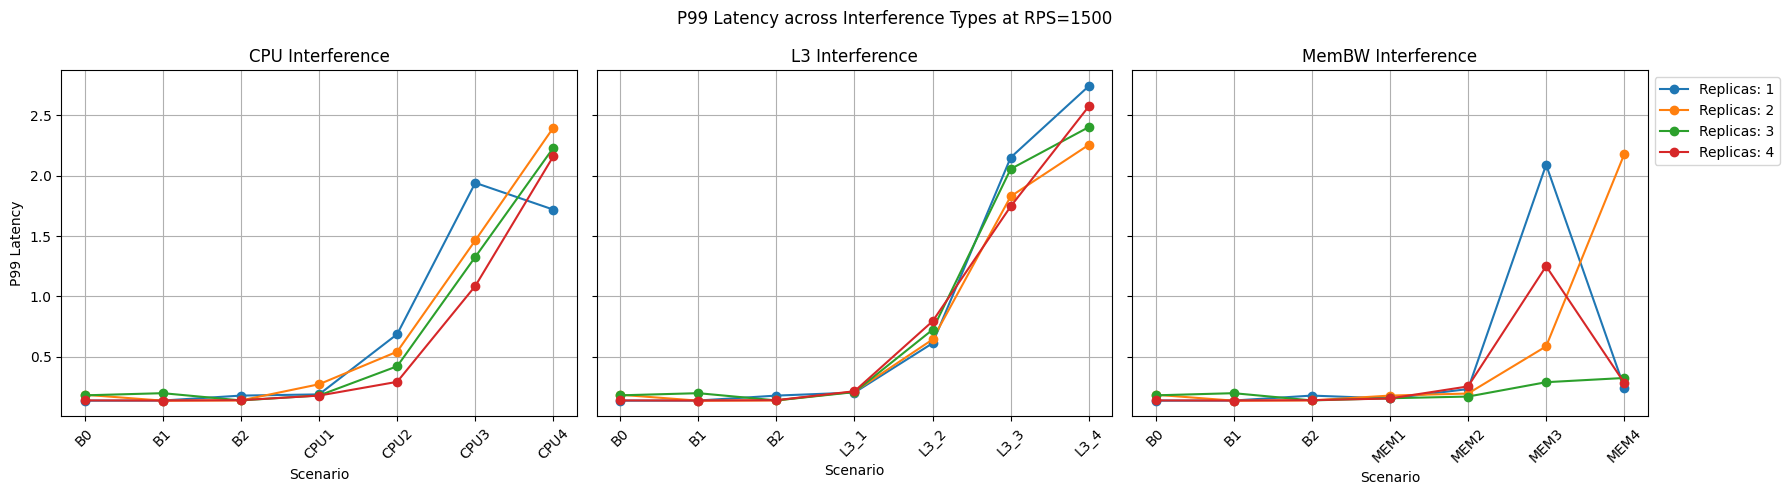

In [52]:
plot_perf_by_rps(df_perf, target_rps=1500)
#plot_perf_by_replica(df_perf, target_replica=1)

### 2.1 Normalized Perfomance
**Formula:**  
$$
\mathrm{NormalizedPerf} \;=\; \frac{\mathrm{Perf}_{\text{baseline}}}{\mathrm{Perf}_{\text{interference}}}
$$

*(Perf = p90 latency, so lower is better)*

**Usage**  
- Compares “what fraction of baseline performance remains” under interference.  
- Ideal for benchmarking across heterogeneous workloads or hardware.  
- Plots easily on a uniform [0–1] scale where 1.0 means no impact.

**Why We Need It**  
- Provides a **relative**, unit‐free measure of interference impact.  
- Allows apples-to-apples comparison even when absolute latencies differ.  
- Highlights which co-locations preserve most of their performance.

In [53]:
def compute_normalized_performance(df_perf, metric='P99_Latency'):
    baseline_names = ["Baseline0", "Baseline1", "Baseline2"]

    # Filter baseline entries
    df_baseline = df_perf[df_perf["Interference_Name"].isin(baseline_names)]

    # Compute baseline means for each (Replicas, RPS) pair
    df_baseline_mean = df_baseline.groupby(["Replicas", "Given_RPS"]).agg({
        "Throughput": "mean",
        "Avg_Latency": "mean",
        "P50_Latency": "mean",
        "P75_Latency": "mean",
        "P90_Latency": "mean",
        "P95_Latency": "mean",
        "P99_Latency": "mean",
        "Max_Latency": "mean"
    }).reset_index()

    # Create lookup dictionary for (Replicas, Given_RPS) -> baseline P99
    baseline_metric_lookup = df_baseline_mean.set_index(["Replicas", "Given_RPS"])[metric].to_dict()

    def compute_norm_perf(row):
        key = (row["Replicas"], row["Given_RPS"])
        baseline_metric = baseline_metric_lookup.get(key, None)

        if row["Interference_Name"] in baseline_names:
            return 1.0
        elif baseline_metric is not None and row[metric] != 0:
            return baseline_metric / row[metric]
        else:
            return float('nan')

    df_perf = df_perf.copy()
    df_perf["norm_perf"] = df_perf.apply(compute_norm_perf, axis=1)
    return df_perf

# Example usage:
df_perf = compute_normalized_performance(df_perf)


In [54]:
df_perf

,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002275,0.087,0.084,0.0,0.100,0.108,0.150,3.678,0.0,Baseline,1.000000
1,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0.0,Baseline,1.000000
2,1replicas_scenario0_1500rps,1,Baseline0,0,1500,1500.001072,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0,Baseline,1.000000
3,1replicas_scenario0_2000rps,1,Baseline0,0,2000,2000.001316,0.088,0.085,0.0,0.109,0.119,0.150,3.523,0.0,Baseline,1.000000
4,1replicas_scenario0_2500rps,1,Baseline0,0,2500,2500.006560,0.092,0.088,0.0,0.116,0.131,0.172,3.640,0.0,Baseline,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,4replicas_scenario34_2500rps,4,4_iBench_memBW_pods,34,2500,2500.013178,0.143,0.104,0.0,0.201,0.256,1.024,4.996,0.0,Membw,0.146810
732,4replicas_scenario34_3000rps,4,4_iBench_memBW_pods,34,3000,3000.000736,0.162,0.108,0.0,0.230,0.322,1.549,5.602,0.0,Membw,0.108672
733,4replicas_scenario34_3500rps,4,4_iBench_memBW_pods,34,3500,3500.004883,0.187,0.124,0.0,0.294,0.412,1.622,7.018,0.0,Membw,0.116934
734,4replicas_scenario34_4000rps,4,4_iBench_memBW_pods,34,4000,3999.999302,0.140,0.114,0.0,0.221,0.282,0.501,4.932,0.0,Membw,0.493014


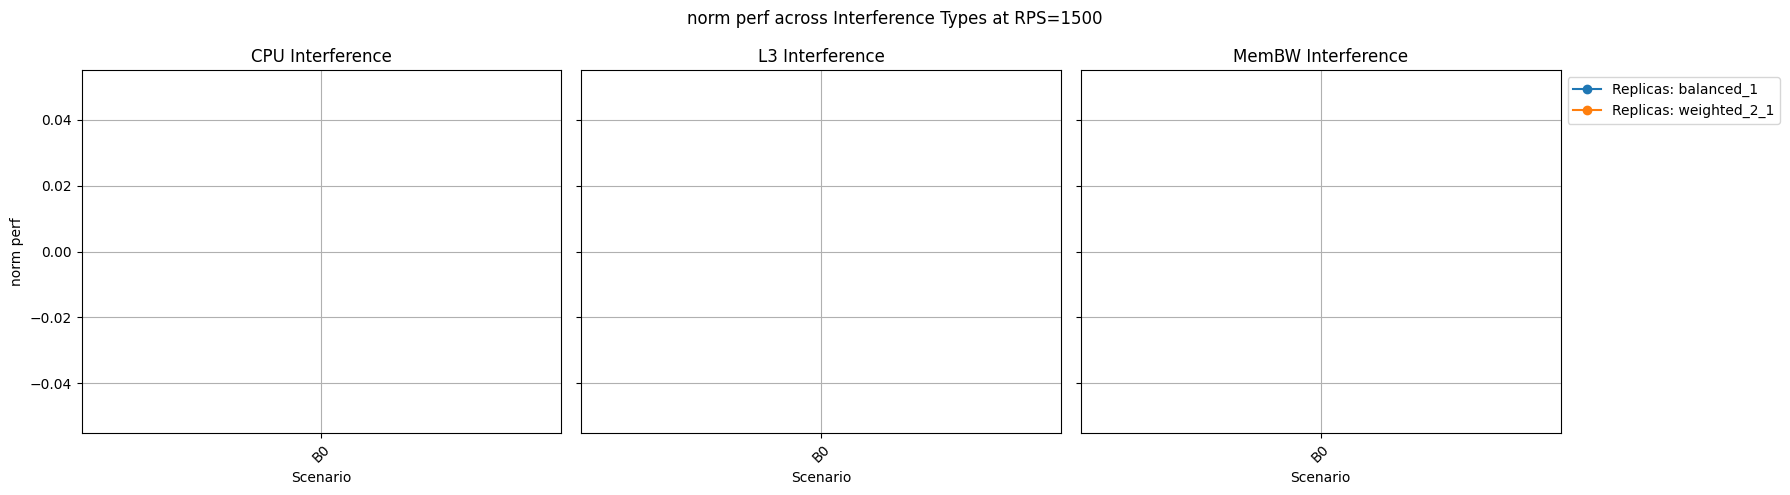

In [55]:
plot_perf_by_rps(df_perf, target_rps=1500, metric='norm_perf', replicas_to_plot=["balanced_1", "weighted_2_1"])

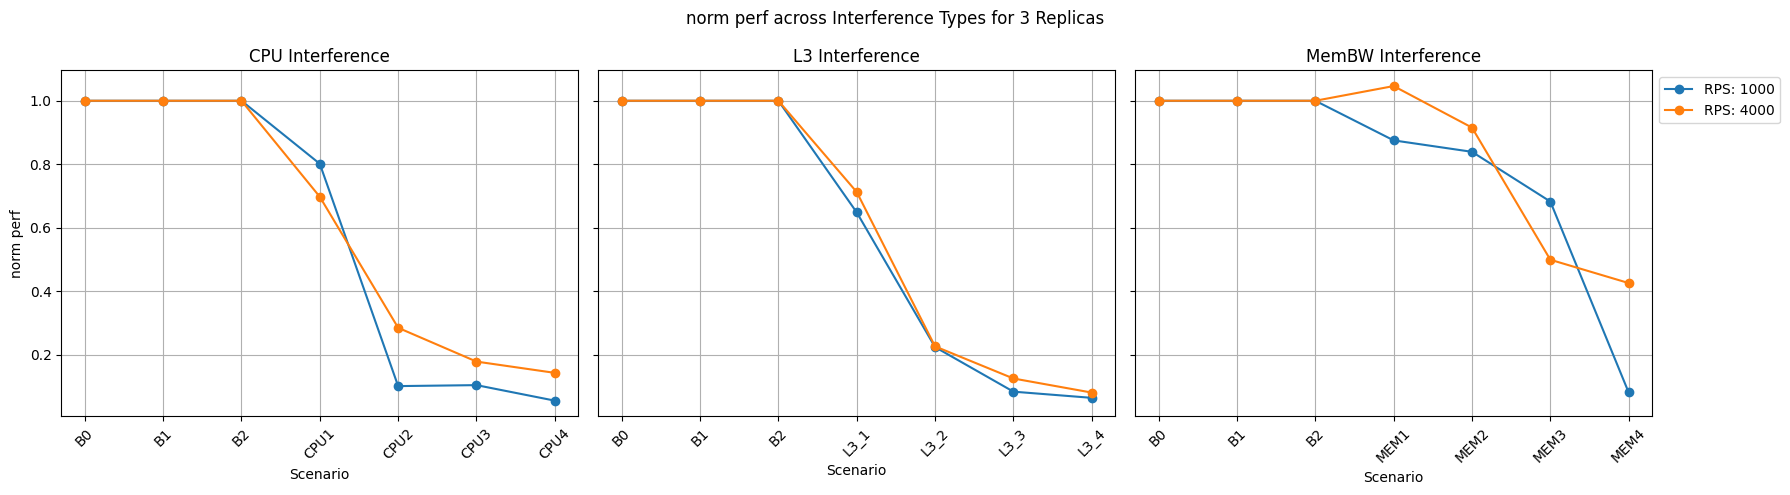

In [56]:
plot_perf_by_replica(df_perf, target_replica=3, metric='norm_perf', rps_to_plot=[1000, 4000])

### 2.2 QoS Degradation
**Formula:**  
$$
\mathrm{QoS\_Degrad\%} \;=\; \frac{\mathrm{Perf}_{\text{with-intf}} \;-\; \mathrm{Perf}_{\text{alone}}}{\mathrm{Perf}_{\text{alone}}} \times 100\%
$$
**Usage**  
- Reports the **absolute** (or percentage) change in your QoS metric (e.g. +20 ms p90).  
- Ideal for capacity-planning (“each co-tenant adds this many milliseconds of tail latency”).

**Why We Need It**  
- Conveys the **magnitude** of slowdown in concrete units.  
- Helps operators budget additional latency and plan SLAs.

### 2.3 SLO Violation

**Formula:**  
$$
\mathrm{SLO\_ViolRate} \;=\; \frac{\bigl|\{\text{requests with latency} > \text{SLO\_threshold}\}\bigr|}{\text{total requests}}
$$

**Usage**  
- Measures the **fraction** (or count) of requests that breach your latency SLO.  
- Reported as a % or per-million rate, often over time or per scenario.

**Why We Need It**  
- Directly ties interference to user-visible failures or timeouts.  
- Captures threshold effects where small latency shifts cause large violation spikes.

### 2.4 Interference Sensitivity

**Formula**  
$$
\mathrm{Sensitivity} \;=\; \frac{\mathrm{Perf}_{\text{alone}} - \mathrm{Perf}_{\text{with-intf}}}{\mathrm{Perf}_{\text{alone}}}
\;=\; 1 \;-\; \mathrm{NormalizedPerf}
$$

**Usage**  
- Ranks workloads by **percent degradation** under interference.  
- Drives scheduler heuristics: e.g. “never co-locate two pods with > 30 % sensitivity.”  
- Plots as a single “pain score” per interference scenario.

**Why We Need It**  
- A concise score of how badly each service suffers.  
- Simplifies placement decisions by collapsing multiple metrics into one.  
- Highlights which pods need strongest isolation or resource guarantees.

##  3 Profiling: 

### **Given the state of the Server, what will the effect on the Application's Perfomance be?**

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.

**Why calculate p95?**

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.



In [57]:
def compute_windowed_stats(series, window_size, stats):
    """Compute rolling-window-based stats for a Series."""
    results = {}
    if window_size:
        win = series.rolling(window=window_size, center=True, min_periods=1)
        if 'mean' in stats: results['mean'] = win.mean().mean()
        if 'std' in stats: results['std'] = win.std().mean()
        if 'max' in stats: results['max'] = win.max().mean()
        if 'min' in stats: results['min'] = win.min().mean()
        if 'p95' in stats: results['p95'] = win.quantile(0.95).mean()
    else:
        if 'mean' in stats: results['mean'] = series.mean()
        if 'std' in stats: results['std'] = series.std()
        if 'max' in stats: results['max'] = series.max()
        if 'min' in stats: results['min'] = series.min()
        if 'p95' in stats: results['p95'] = series.quantile(0.95)
    return results


import pandas as pd
from typing import Dict, List

def compute_core_features_from_df(
    df_pcm: pd.DataFrame,
    target_cores: List[int] = [3, 4, 5],
    window_size: int = 2,
    stats: List[str] = ['mean', 'p95', 'std'],
    core_prefix_template: str = "Core{core} (Socket 0) - "
) -> Dict[str, float]:
    """
    Computes per-core and AvgCore PCM stats from a single PCM DataFrame.

    Parameters:
    - df_pcm: DataFrame with time-series PCM metrics
    - target_cores: cores to analyze (default [3,4,5])
    - window_size: window for rolling stat calculation
    - stats: stats to compute (e.g., ['mean','std','p95'])
    - core_prefix_template: pattern for column prefix

    Returns:
    - Dict of {feature_name: value}
    """
    from collections import defaultdict

    features = {}
    core_metrics_group = defaultdict(list)

    # Metrics we care about
    keep_metrics = ['IPC', 'L3MISS', 'L2MISS', 'C0res%', 'C1res%', 'C6res%', 'PhysIPC']

    for core in target_cores:
        core_prefix = core_prefix_template.format(core=core)
        core_cols = [col for col in df_pcm.columns if col.startswith(core_prefix)]
        core_cols = [col for col in core_cols if any(m in col for m in keep_metrics)]

        for col in core_cols:
            metric = col.replace(core_prefix, '').replace('%', '')
            clean_name = f'Core{core}_{metric}'
            series = df_pcm[col]

            stat_values = compute_windowed_stats(series, window_size, stats)
            for stat, value in stat_values.items():
                features[f'{stat}_{clean_name}'] = value

            core_metrics_group[metric].append(series)

    # Compute aggregated AvgCore metrics
    for metric, series_list in core_metrics_group.items():
        continue
        if series_list:
            df_metric = pd.concat(series_list, axis=1)
            agg_series = df_metric.mean(axis=1)  # row-wise average
            agg_stats = compute_windowed_stats(agg_series, window_size, stats)
            for stat, value in agg_stats.items():
                features[f'{stat}_AvgCore_{metric}'] = value

    return features


In [ ]:
import os
import glob
import pandas as pd

def extract_pcm(data_dir: str,target_cores: list = [3, 4, 5],window_size: int = 2,stats: tuple = ('mean', 'p95', 'std'),core_prefix_template: str = 'Core{core} (Socket 0) - ') -> pd.DataFrame:
    """
    Processes a single directory containing pcm_core CSVs.
    Returns a one-row DataFrame of extracted features.
    """
    # Find core CSV files
    core_pattern = os.path.join(data_dir, 'pcm_core_*.csv')
    core_files = glob.glob(core_pattern)

    if not core_files:
        print(f"⚠️ No PCM core files found in {data_dir}")
        return pd.DataFrame()

    # Load and process each core file (usually 1 per folder)
    all_features = []
    for path in core_files:
        df_pcm = pd.read_csv(path)
        feature_dict = compute_core_features_from_df(
            df_pcm,
            target_cores=target_cores,
            window_size=window_size,
            stats=stats,
            core_prefix_template=core_prefix_template
        )

        # Add scenario info (e.g., from filename)
        pcm_id = os.path.basename(path).replace('pcm_core_', '').replace('.csv', '')
        feature_dict['Test_ID'] = pcm_id
        # Optionally extract replicas and RPS
        import re
        match_rps = re.search(r'(\d+)rps', pcm_id)
        match_rep = re.search(r'(\d+)replicas', pcm_id)
        if match_rps:
            feature_dict['RPS'] = int(match_rps.group(1))
        if match_rep:
            feature_dict['Replicas'] = int(match_rep.group(1))

        all_features.append(feature_dict)

    df_result = pd.DataFrame(all_features)
    if not df_result.empty:
        folder_name = os.path.basename(data_dir)
        df_result["FolderID"] = folder_name
        df_result["UniqueID"] = df_result["Test_ID"].astype(str) + "_" + folder_name

    return df_result


In [ ]:
def extract_from_multiple_dirs(dirs: list,**kwargs) -> pd.DataFrame:
    """
    Runs extract_pcm() for each directory in `dirs` and concatenates the results.
    kwargs are passed to extract_pcm().
    """
    all_dfs = []
    for d in dirs:
        df = extract_pcm(d, **kwargs)
        if not df.empty:
            all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()


In [ ]:
Target_Cores = [3, 4, 5]
stats = ('mean', 'p95', 'std')

df_features = extract_from_multiple_dirs(folders,target_cores=Target_Cores,window_size=2,stats=stats)

In [61]:
display(df_features)

,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,mean_Core3_C0res,...,mean_Core5_C6res,std_Core5_C6res,p95_Core5_C6res,mean_Core5_PhysIPC,std_Core5_PhysIPC,p95_Core5_PhysIPC,Test_ID,RPS,Replicas,SourceDir
0,0.841892,0.148885,0.934081,0.012838,0.003732,0.015149,0.548108,0.029070,0.566108,1.914595,...,0.0,0.0,0.0,59.057162,8.793462,64.502041,1replicas_scenario31_3000rps,3000,1,Memento_V01
1,0.690270,0.015713,0.700000,0.009730,0.000393,0.009973,0.324054,0.018463,0.335486,1.027973,...,0.0,0.0,0.0,35.689865,2.146265,37.018824,1replicas_scenario0_1500rps,1500,1,Memento_V01
2,1.677027,0.092710,1.734432,0.010000,0.000000,0.010000,0.041622,0.002357,0.043081,1.523514,...,0.0,0.0,0.0,41.141892,7.939238,46.057838,1replicas_scenario32_100rps,100,1,Memento_V01
3,1.184054,0.616361,1.565703,0.021486,0.002946,0.023311,0.317568,0.015713,0.327297,1.323108,...,0.0,0.0,0.0,116.128243,25.977335,132.213311,1replicas_scenario21_3500rps,3500,1,Memento_V01
4,0.699730,0.020820,0.712622,0.010000,0.000000,0.010000,0.442568,0.015517,0.452176,1.367838,...,0.0,0.0,0.0,37.052162,1.205224,37.798432,1replicas_scenario1_2500rps,2500,1,Memento_V01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,1.445000,0.173830,1.552635,0.010000,0.000000,0.010000,0.215135,0.022785,0.229243,1.817703,...,0.0,0.0,0.0,60.714189,6.402263,64.678446,1replicas_scenario52_2500rps,2500,1,Memento_V01_mix_scenarios
732,1.820270,0.562936,2.168838,0.020946,0.002946,0.022770,0.300946,0.025338,0.316635,2.101486,...,0.0,0.0,0.0,95.927838,22.597169,109.919919,1replicas_scenario51_3000rps,3000,1,Memento_V01_mix_scenarios
733,2.168243,0.559596,2.514743,0.020541,0.002750,0.022243,0.241757,0.020231,0.254284,2.304054,...,0.0,0.0,0.0,108.999324,18.687457,120.570527,1replicas_scenario51_2000rps,2000,1,Memento_V01_mix_scenarios
734,1.469189,0.078960,1.518081,0.010270,0.000393,0.010514,0.254730,0.016303,0.264824,1.965541,...,0.0,0.0,0.0,62.177973,2.634955,63.809527,1replicas_scenario52_3000rps,3000,1,Memento_V01_mix_scenarios


### 3.2. Label Joining & Normalized Performance

**Objective:**  
Merge each hardware‐counter feature vector (`df_features`) with its corresponding observed tail‐latency, then convert raw latencies into a _normalized slowdown ratio_ that becomes our RiskScore target (`norm_perf`).

**Steps:**

1. **Extract per-traffic baseline latency and Compute slowdown ratio**  
    - For each `Interference` scenario, extract the baseline latency (e.g. P99) from the row where `Interference = "baseline"`.  
    - Compute the slowdown ratio:  
      ```python
      df_perf['Normalized_Performance'] = df_perf['P99_Latency'] / df_perf['Baseline_P99_Latency']
      ```
    - This gives us a measure of how much worse the latency is under interference compared to the baseline.

3. **Merge with features and set RiskScore**  
   - Inner‐join your feature table on the `Interference` column
   - The resulting `df_ml` contains one row per experiment, with:
     - all hardware‐counter summaries
     - the normalized target `norm_perf` (Risk < 1 ⇒ likely SLO violation)

**Why use norm_perf column?**  
- **Workload-agnostic target:** by normalizing against each test’s own baseline, the model doesn’t need to learn absolute latencies for every traffic pattern—only how much interference slows it down.  
- **Aligned with SLOs:** `norm_perf` becomes a direct proxy for “fraction of SLO consumed” (e.g. predicted P99 / SLO_ms), so a learned model can output a true RiskScore that the scheduler uses to decide placement or mitigation.


In [62]:
display(df_perf)
print(df_perf.columns)

,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,1replicas_scenario0_1000rps,1,Baseline0,0,1000,1000.002275,0.087,0.084,0.0,0.100,0.108,0.150,3.678,0.0,Baseline,1.000000
1,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0.0,Baseline,1.000000
2,1replicas_scenario0_1500rps,1,Baseline0,0,1500,1500.001072,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0,Baseline,1.000000
3,1replicas_scenario0_2000rps,1,Baseline0,0,2000,2000.001316,0.088,0.085,0.0,0.109,0.119,0.150,3.523,0.0,Baseline,1.000000
4,1replicas_scenario0_2500rps,1,Baseline0,0,2500,2500.006560,0.092,0.088,0.0,0.116,0.131,0.172,3.640,0.0,Baseline,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,4replicas_scenario34_2500rps,4,4_iBench_memBW_pods,34,2500,2500.013178,0.143,0.104,0.0,0.201,0.256,1.024,4.996,0.0,Membw,0.146810
732,4replicas_scenario34_3000rps,4,4_iBench_memBW_pods,34,3000,3000.000736,0.162,0.108,0.0,0.230,0.322,1.549,5.602,0.0,Membw,0.108672
733,4replicas_scenario34_3500rps,4,4_iBench_memBW_pods,34,3500,3500.004883,0.187,0.124,0.0,0.294,0.412,1.622,7.018,0.0,Membw,0.116934
734,4replicas_scenario34_4000rps,4,4_iBench_memBW_pods,34,4000,3999.999302,0.140,0.114,0.0,0.221,0.282,0.501,4.932,0.0,Membw,0.493014


Index(['Test_ID', 'Replicas', 'Interference_Name', 'Interference_ID',
       'Given_RPS', 'Throughput', 'Avg_Latency', 'P50_Latency', 'P75_Latency',
       'P90_Latency', 'P95_Latency', 'P99_Latency', 'Max_Latency', 'Errors',
       'Interference_Category', 'norm_perf'],
      dtype='object')


In [63]:
def merge_features_with_performance(df_features, df_perf):
    """
    Merge PCM features with latency performance metrics on 'Test_ID'.
    
    Parameters:
    - df_features: DataFrame from PCM feature extraction
    - df_perf: DataFrame with latency metrics and norm_perf
    
    Returns:
    - Merged DataFrame ready for model training
    """
    merged_df = pd.merge(df_features, df_perf, on='Test_ID', how='inner')
    
    print(f"✅ Merged shape: {merged_df.shape}")
    print(f"🔍 Columns: {merged_df.columns.tolist()[:10]}... + {len(merged_df.columns)-10} more")
    
    return merged_df

In [64]:
df_ml = merge_features_with_performance(df_features, df_perf)
display(df_ml)

✅ Merged shape: (736, 82)
🔍 Columns: ['mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'p95_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'p95_Core3_L2MISS', 'mean_Core3_C0res']... + 72 more


,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,mean_Core3_C0res,...,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,0.841892,0.148885,0.934081,0.012838,0.003732,0.015149,0.548108,0.029070,0.566108,1.914595,...,0.099,0.091,0.0,0.132,0.150,0.217,4.026,0.0,Membw,0.935484
1,0.690270,0.015713,0.700000,0.009730,0.000393,0.009973,0.324054,0.018463,0.335486,1.027973,...,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0,Baseline,1.000000
2,1.677027,0.092710,1.734432,0.010000,0.000000,0.010000,0.041622,0.002357,0.043081,1.523514,...,0.306,0.296,0.0,0.444,0.523,0.613,2.324,0.0,Membw,0.976618
3,1.184054,0.616361,1.565703,0.021486,0.002946,0.023311,0.317568,0.015713,0.327297,1.323108,...,0.119,0.109,0.0,0.170,0.196,0.282,3.680,0.0,L3,0.698582
4,0.699730,0.020820,0.712622,0.010000,0.000000,0.010000,0.442568,0.015517,0.452176,1.367838,...,0.090,0.087,0.0,0.113,0.126,0.158,3.704,0.0,Baseline,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,1.445000,0.173830,1.552635,0.010000,0.000000,0.010000,0.215135,0.022785,0.229243,1.817703,...,0.127,0.094,0.0,0.165,0.211,0.969,5.353,0.0,Other,0.168559
732,1.820270,0.562936,2.168838,0.020946,0.002946,0.022770,0.300946,0.025338,0.316635,2.101486,...,0.127,0.107,0.0,0.161,0.188,0.496,5.108,0.0,Other,0.409274
733,2.168243,0.559596,2.514743,0.020541,0.002750,0.022243,0.241757,0.020231,0.254284,2.304054,...,0.150,0.120,0.0,0.207,0.248,0.776,8.117,0.0,Other,0.222938
734,1.469189,0.078960,1.518081,0.010270,0.000393,0.010514,0.254730,0.016303,0.264824,1.965541,...,0.125,0.093,0.0,0.151,0.194,1.005,4.954,0.0,Other,0.201990


In [65]:
# Sanity check
missing_ids = set(df_perf["Test_ID"]) - set(df_features["Test_ID"])
if missing_ids:
    print(f"⚠️ Missing Test_IDs in features: {missing_ids}")


### 3.3. Preprocessing & Pipeline Construction

**Objective:**  
Turn our raw hardware‐counter summaries into a compact, consistent input for a regressor that predicts the slowdown ratio (`Risk_obs`), while avoiding overfitting on just 24 experiments.

---

#### 1. Feature Selection  
- **Include all sliding-window stats:**  
  - `mean_`, `std_`, `p95_`  
- **Why?** These five measures per counter capture central tendency, variability, peaks, troughs, and tail‐behavior bursts—key signals for tail-latency.

#### 2. The Pipeline & Its Steps  
- **StandardScaler**: Normalize each feature to zero mean and unit variance.
- **PolynomialFeatures**: Expand the feature set with polynomial combinations of the original features.
- **PCA**: Reduce dimensionality while preserving variance.
- **RandomForestRegressor**: Train a regression model to predict the slowdown ratio.


In [66]:
# 1. Define the input features
stat_prefixes = ('mean_', 'std_', 'p95_')
feature_cols = [col for col in df_ml.columns if col.startswith(stat_prefixes) or col in ('RPS', 'Replicas_x')]

X = df_ml[feature_cols]
y = df_ml['norm_perf']

# 2. Build the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),                                       # Normalize inputs
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),         # Expand features
    ('pca', PCA(n_components=0.95, random_state=42)),                   # Keep 95% of variance
    ('reg', RandomForestRegressor(n_estimators=100, random_state=42))   # Train RF
])

In [67]:
print(X.shape, y.shape)
print(f"Features: {len(X.columns)} | Samples: {len(X)}")
# Print names of the features
print("Feature names:", X.columns.tolist())

(736, 65) (736,)
Features: 65 | Samples: 736
Feature names: ['mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'p95_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'p95_Core3_L2MISS', 'mean_Core3_C0res', 'std_Core3_C0res', 'p95_Core3_C0res', 'mean_Core3_C1res', 'std_Core3_C1res', 'p95_Core3_C1res', 'mean_Core3_C6res', 'std_Core3_C6res', 'p95_Core3_C6res', 'mean_Core3_PhysIPC', 'std_Core3_PhysIPC', 'p95_Core3_PhysIPC', 'mean_Core4_IPC', 'std_Core4_IPC', 'p95_Core4_IPC', 'mean_Core4_L3MISS', 'std_Core4_L3MISS', 'p95_Core4_L3MISS', 'mean_Core4_L2MISS', 'std_Core4_L2MISS', 'p95_Core4_L2MISS', 'mean_Core4_C0res', 'std_Core4_C0res', 'p95_Core4_C0res', 'mean_Core4_C1res', 'std_Core4_C1res', 'p95_Core4_C1res', 'mean_Core4_C6res', 'std_Core4_C6res', 'p95_Core4_C6res', 'mean_Core4_PhysIPC', 'std_Core4_PhysIPC', 'p95_Core4_PhysIPC', 'mean_Core5_IPC', 'std_Core5_IPC', 'p95_Core5_IPC', 'mean_Core5_L3MISS', 'std_Core5_L3MISS', 'p95_Core5_L3MISS', 'm

### 3.4 Model Training & Evaluation

**Objective:**  
Assess how well our pipeline predicts the normalized slowdown (`norm_perf`) on interference scenarios it hasn’t seen, and quantify the expected error.

1. **Cross-Validation Strategy**  
   - We use **Leave-One-Interference-Level-Out** (LeaveOneGroupOut) CV, grouping by the `Interference` label.  
   - Each fold trains on all but one interference intensity (e.g. CPU×2, MemBW×4, etc.) and tests on the held-out level—mimicking how we need to generalize to new contention patterns.

2. **Scoring Metrics**  
   - **Mean Squared Error (MSE):** penalizes large deviations heavily; tells us how far off our predicted slowdown is, on average, in squared units.  
   - **Mean Absolute Error (MAE):** more interpretable “on average we’re ±X% off” in the slowdown ratio.

3. **Interpreting Results**  
   - A low MAE (e.g. 0.05) means we predict that a node’s tail latency will be within 5% of its true slowdown.  
   - These errors guide confidence in scheduling decisions: if the predicted slowdown differences between two nodes exceed our MAE, we can reliably pick the best node.

4. **Scheduler Integration**  
   - At runtime, the scheduler will load this **trained pipeline**, sample live hardware counters on each node, and compute `predicted_norm_perf`.  
   - It then assigns new pods to the node with the lowest predicted slowdown, or triggers mitigation if all nodes exceed an acceptable threshold.

By successfully completing this subsection, we’ll have a validated, quantifiable predictor of interference-induced slowdowns—our RiskScore—that the scheduler can trust for placement decisions.  


In [68]:
# 1. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Fit pipeline
pipeline.fit(X_train, y_train)

print(f"Pipeline fitted with {len(X_train)} training samples and {len(X_test)} test samples.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# 3. Predict and evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 4. PCA variance retention
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_.sum()

# 5. Output results
print(f"✅ MAE: {mae:.4f}")
print(f"📈 R²: {r2:.4f}")
print(f"📊 PCA retained variance: {explained_variance:.1%}")

Pipeline fitted with 588 training samples and 148 test samples.
X_train shape: (588, 65), y_train shape: (588,)
✅ MAE: 0.1114
📈 R²: 0.7795
📊 PCA retained variance: 95.2%


In [69]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"📉 Cross-validated MAE: {-cv_scores.mean():.4f}")

📉 Cross-validated MAE: 0.1217


### 3.5 Testing the Predictor on Real Data

**Goal:** Given a fresh PCM trace, forecast its slowdown and compare it against the single observed P90 latency.

1. **Feature Extraction**  
   - We call `extract_pcm_features(...)` on the `HR_Test` folder to compute the same sliding-window stats used during training.

2. **Prediction**  
   - We pass those stats into `model_pipeline.predict(...)` and capture `predicted_Risk`, our model’s estimate of slowdown (e.g., 5× slower than baseline).

3. **Observe True P90**  
   - We read the lone `P90_Latency` value from `workload_metrics.csv` (e.g., 46970 ms).

4. **Baseline Reference**  
   - We fetch the original baseline P90 (9430 ms) from our training DataFrame (`df_perf`), without relying on labels in the test CSV.

5. **Compute Actual Slowdown**  
   - `actual_Risk = observed_p90 / baseline_p90` (e.g., 46970 / 9430 ≈ 4.98).

6. **Comparison**  
   - Present a simple table showing `predicted_Risk` vs. `actual_Risk`.  
   - Close agreement validates that our offline-trained pipeline delivers reliable slowdown estimates for scheduler decision-making.


In [70]:
import os
import pandas as pd

# --- 1. Extract PCM features for the test run ---
test_dir   = "Nginx_Test"
traffic_id = "light-test_cpu_1_l3_1"      # matches the suffix in pcm_system_metrics_TC-VM-01_test.csv
window_size = 5              # same window size used during training
stats       = ('mean','std','p95')

df_test_feat = extract_pcm_features(
    data_dir=test_dir
)

# --- 2. Predict slowdown ratio with the trained pipeline ---
feature_cols = [c for c in df_test_feat.columns if c.startswith(('mean_','std_','p95_'))]
X_test        = df_test_feat[feature_cols]
predicted_risk = model_pipeline.predict(X_test)[0]

# --- 3. Load the observed P90 latency for this test run ---
df_workload = pd.read_csv(os.path.join(test_dir, "workload_metrics.csv"))
observed_p90 = df_workload["P99_Latency"].iloc[0]    # e.g. 46970.0 ms

# --- 4. Look up the baseline P90 latency from the training data (df_perf) ---
baseline_p90 = 638.0 ## Medium Traffic - Baseline P90 Latency

# --- 5. Compute the actual slowdown ratio ---
actual_risk = baseline_p90 / observed_p90

# --- 6. Display predicted vs. actual slowdown ---
error_percent = 100 * abs(predicted_risk - actual_risk) / actual_risk

result = pd.DataFrame({
    "predicted_Risk": [predicted_risk],
    "actual_Risk":    [actual_risk],
    "error_percent":  [error_percent]
})
print("Predicted vs. Actual Slowdown Ratios:")
display(result)


NameError: name 'extract_pcm_features' is not defined

## 4. Exporting the Predictor

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [71]:
import joblib
import os
import pickle

# Define save path
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

# Save full pipeline
# Save model
with open("models/slowdown_predictor.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print(f"✅ Trained model pipeline saved to /model")


✅ Trained model pipeline saved to /model
